# Handwritten Equation Grading

This is a model submitted to the [2020 UIdaho Data Science Competition](https://dscomp.nkn.uidaho.edu/scoring)

In [1]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout, MaxPool2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import image, ImageDataGenerator
from keras import backend as K
from keras.models import Model, Sequential, load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

Using TensorFlow backend.


In [0]:
# To use on Google Colab
# !pip install tensorflow-gpu==1.15.2

In [0]:
# Download data
!wget -c https://dscomp.nkn.uidaho.edu/datadownload/Competition_Train_data_8000.npy
!wget -c https://dscomp.nkn.uidaho.edu/datadownload/Competition_Train_label_8000.npy
!wget -c https://dscomp.nkn.uidaho.edu/datadownload/Competition_Problems.npy

In [3]:
# load data

### Train Data
Train_data = np.load('Competition_Train_data_8000.npy')  # Your directory
print(Train_data.shape)

### Train Label
Train_label = np.load('Competition_Train_label_8000.npy') 
print(Train_label.shape)

(8000, 64, 64)
(8000,)


In [4]:
# reshape
x_train = np.reshape(Train_data, [Train_data.shape[0], Train_data.shape[1], Train_data.shape[2], 1])
print('Training set: {}'.format(x_train.shape))

Training set: (8000, 64, 64, 1)


In [5]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = False,  # randomly flip images
    vertical_flip = False)  # randomly flip images)

datagen.fit(x_train)

multiplier = 5
m = x_train.shape[0]
augment_size = multiplier * m # generate 'multiplier' times more data

randidx = np.random.randint(m, size = augment_size)

x_augmented = x_train[randidx].copy()
y_augmented = Train_label[randidx].copy()

x_augmented, y_augmented = datagen.flow(x_augmented, y_augmented, batch_size = augment_size, shuffle = False).next()

# append augmented data to the training set
x_train = np.concatenate((x_train, x_augmented))
y_train = np.concatenate((Train_label, y_augmented))

print(x_train.shape)
print(y_train.shape)

(48000, 64, 64, 1)
(48000,)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

print('Training set: {} and Training Targets: {}'.format(x_train.shape, y_train.shape))
print('Test set: {} and test targets: {}'.format(x_test.shape, y_test.shape))

# normalize data
x_train /= 255.0
x_test /= 255.0

# one-hot-encode labels
y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)

print('One-hot training labels: {}'.format(y_train_onehot.shape))
print('One-hot test labels: {}'.format(y_test_onehot.shape))

Training set: (38400, 64, 64, 1) and Training Targets: (38400,)
Test set: (9600, 64, 64, 1) and test targets: (9600,)
One-hot training labels: (38400, 16)
One-hot test labels: (9600, 16)


In [7]:
# Convnet
model = Sequential()

# layers
model.add(Conv2D(filters = 16, kernel_size = (11, 11),padding = 'Same', activation ='relu', input_shape = (64, 64, 1)))
model.add(Conv2D(filters = 16, kernel_size = (11, 11),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(filters = 32, kernel_size = (7, 7),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (7, 7),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5, 5),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (5, 5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128, kernel_size = (3, 3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3, 3),padding = 'Same', activation ='relu'))

model.add(Conv2D(filters = 256, kernel_size = (3, 3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 256, kernel_size = (3, 3),padding = 'Same', activation ='relu'))

model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

# fully connected layers
model.add(Flatten())
model.add(Dense(256, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.0001)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.0001)))
model.add(Dense(64, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.0001)))
model.add(Dropout(0.5))
model.add(Dense(16, activation = "softmax", kernel_regularizer = tf.keras.regularizers.l2(0.0001)))

checkpoint = ModelCheckpoint('best_model.hdf5', verbose = 1, save_best_only = True)

optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1952      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        30992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        25120     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)       

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 0, factor = 0.5, min_lr = 0.00001)

In [9]:
# Train the model

epochs = 70
batch_size = 128

history = model.fit_generator(
    datagen.flow(x_train,y_train_onehot, batch_size = batch_size),
    epochs = epochs,
    steps_per_epoch = x_train.shape[0]//batch_size,
    validation_data = (x_test, y_test_onehot),
    callbacks = [learning_rate_reduction, checkpoint],
    verbose = 1)

Epoch 1/70
300/300 [==============================] - 34s 113ms/step - loss: 1.8769 - accuracy: 0.3721 - val_loss: 4.5711 - val_accuracy: 0.0826

Epoch 00001: val_loss improved from inf to 4.57108, saving model to best_model.hdf5
Epoch 2/70
  1/300 [..............................] - ETA: 16s - loss: 1.3372 - accuracy: 0.5391

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


300/300 [==============================] - 24s 79ms/step - loss: 1.0511 - accuracy: 0.6350 - val_loss: 1.1926 - val_accuracy: 0.6157

Epoch 00002: val_loss improved from 4.57108 to 1.19255, saving model to best_model.hdf5
Epoch 3/70
300/300 [==============================] - 24s 79ms/step - loss: 0.7099 - accuracy: 0.7440 - val_loss: 0.4764 - val_accuracy: 0.8385

Epoch 00003: val_loss improved from 1.19255 to 0.47642, saving model to best_model.hdf5
Epoch 4/70
300/300 [==============================] - 24s 79ms/step - loss: 0.5200 - accuracy: 0.8467 - val_loss: 0.2917 - val_accuracy: 0.9397

Epoch 00004: val_loss improved from 0.47642 to 0.29174, saving model to best_model.hdf5
Epoch 5/70
300/300 [==============================] - 24s 79ms/step - loss: 0.3599 - accuracy: 0.9155 - val_loss: 0.1638 - val_accuracy: 0.9723

Epoch 00005: val_loss improved from 0.29174 to 0.16383, saving model to best_model.hdf5
Epoch 6/70
300/300 [==============================] - 24s 79ms/step - loss: 0.2

In [0]:
# Extract metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

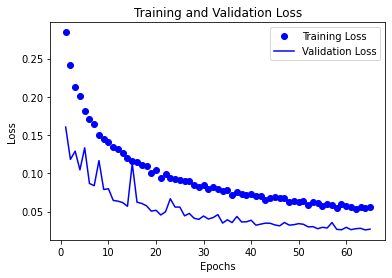

In [11]:
# Visualize loss

a = 5
steps = range(1, len(loss[a:]) + 1)

plt.plot(steps, loss[a:], 'bo', label = 'Training Loss')
plt.plot(steps, val_loss[a:], 'b', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

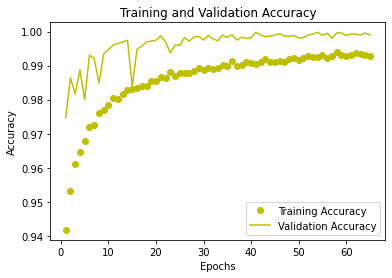

In [12]:
# Visualize accuracy

plt.plot(steps, acc[a:], 'yo', label = 'Training Accuracy')
plt.plot(steps, val_acc[a:], 'y', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [13]:
# Load the test data
Test_data = np.load('Competition_Problems.npy')
# normalize test data
Test_data /= 255.0
Test_data.shape

(20000, 64, 384)

In [0]:
# Load the best model found
model = load_model('best_model.hdf5')

In [15]:
# Make predictions for test data

grades = []
Testsize = 20000

for i in range(Testsize):

    # print every 1000 steps (just for feedback)
    if (i + 1) % 1000 == 0: # i + 1 to avoid printing 0
        print((i + 1)//1000, end = ' ')

    # extract lhs, rhs and c from the image
    lhs_img = Test_data[i][:,60:130]
    lhs_img = cv2.resize(lhs_img, (64, 64))    
    lhs_img_ = np.reshape(lhs_img, [1, lhs_img.shape[0], lhs_img.shape[1], 1])

    rhs_img = Test_data[i][:,250:322]
    rhs_img = cv2.resize(rhs_img, (64, 64))
    rhs_img_ = np.reshape(rhs_img, [1, rhs_img.shape[0], rhs_img.shape[1], 1])

    c_img = Test_data[i][:,315:384]
    c_img = cv2.resize(c_img, (64, 64))    
    c_img_ = np.reshape(c_img, [1, c_img.shape[0], c_img.shape[1], 1])


    # predict lhs, rhs and c labels
    lhs_pred = model.predict(lhs_img_, verbose = 0)
    lhs_pred = np.argmax(lhs_pred,axis = 1)    

    rhs_pred = model.predict(rhs_img_, verbose = 0)
    rhs_pred = np.argmax(rhs_pred, axis = 1)   

    c_pred = model.predict(c_img_, verbose=0)
    c_pred = np.argmax(c_pred,axis = 1)    


    # assign the grades

    ## equ 1
    if lhs_pred == 0:
        if rhs_pred == 7:
            if c_pred == 11:
                grades.append(10)
            else:
                grades.append(9) 
                
        elif rhs_pred == 12:
            if c_pred == 11:
                grades.append(5)
            else:
                grades.append(0)
                
        else:
            grades.append(0)
            
    ### equ 2   
    elif lhs_pred == 1:
        if rhs_pred == 8:
            if c_pred == 11:
                grades.append(10)
            else:
                grades.append(9) 
                
        elif rhs_pred == 13:
            if c_pred == 11:
                grades.append(5)
            else:
                grades.append(0)

        elif rhs_pred == 4:
            if c_pred == 11:
                grades.append(2)
            else:
                grades.append(1)
        else:
            grades.append(0) 
    
    ### equ 3 
    elif lhs_pred == 2:
        if rhs_pred == 9:
            if c_pred == 11:
                grades.append(10)
            else:
                grades.append(9) 
                
        elif rhs_pred == 14:
            if c_pred == 11:
                grades.append(5)
            else:
                grades.append(0)

        elif rhs_pred == 5:
            if c_pred == 11:
                grades.append(2)
            else:
                grades.append(1)
        else:
            grades.append(0) 

    ### equ 4 
    elif lhs_pred == 3:
        if rhs_pred == 10:
            if c_pred == 11:
                grades.append(10)
            else:
                grades.append(9) 
                
        elif rhs_pred == 15:
            if c_pred == 11:
                grades.append(5)
            else:
                grades.append(0)

        elif rhs_pred == 6:
            if c_pred == 11:
                grades.append(2)
            else:
                grades.append(1)
        else:
            grades.append(0) 

    ### equ 5 
    elif lhs_pred == 4:
        if rhs_pred == 1:
            if c_pred == 11:
                grades.append(10)
            else:
                grades.append(9) 
        else:
            grades.append(0) 
            
    ### equ 6 
    elif lhs_pred == 5:
        if rhs_pred == 2:
            if c_pred == 11:
                grades.append(10)
            else:
                grades.append(9) 
        else:
            grades.append(0) 
            
    ### equ 7 
    elif lhs_pred == 6:
        if rhs_pred == 3:
            if c_pred == 11:
                grades.append(10)
            else:
                grades.append(9) 
        else:
            grades.append(0) 
    
    else:
        grades.append(0)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

In [0]:
# Convert to numpy array and save
grades_array = np.array(grades)
np.save('grades-g', grades_array)